<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/PredictThenOptimizeLinReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Then Optimize

 

Predction and optimization have been used together for some time, but thier coupling has only become popular in recent years (partly due to the explosion of big data and machine learning).  The upside is obvious, data scientists are able to link the predictive with the prescriptive, which allows for better decison-making than prediction alone.

Additionally, this strategy makes it easier to link data science to the domains it is used in.  Since optimization and prescriptive analytics broadly make suggestions about what we 'ought' to do, there are junctions where businesses, managers, and other stakeholders can connect their objectives, strategies, and values to the project.  Hopefully, this notebook gives the reader a better idea of how this is possible, despite the fact that it is a modest project that is meant to be little more than an introduction.


# The Data
The data used in this notebook is a canonical marketing dataset.  It has 3  features (newspaper, TV, and radio) and a target (sales), which represents the amount spent by 200 companies in each channel operating in the same market, and the number of sales their efforts generated.

## Business Context

In this hypothetical example, there is a company that is about to enter into the market where the data was collected.  They need to decide how much money to put into each channel to get optimal Return on Investment (ROI).

To do so, they will build a random forest regression model and pass it as part of the objective function of a constrained and bounded optimization problem.  Thus, finding the optimal distribution of their budget among the several channels they are marketing in.  

## Technical Outline



To do so, they will build a random forest regression model and pass it as part of the objective function of a constrained and bounded optimization problem.  Thus, finding the optimal distribution of their budget among the several channels they are marketing in.

Outline:

1. The dataset will be explored and visualized
2. After patterns are found, a polynomial term and an interaction term will be introduced.
3. A random forest regression model will be fit to the data
4.  The model object will be stored and defined as part of an objective function
5. The objective function will be used in a constrained and bounded optimization problem

In addition, the constraints and bounds will be set in a way that mimics the types of real-world constraints that are found in the business world. 

## Import Packages

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import seaborn as sns
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy import stats
import io
from google.colab import files

#Set Style
plt.style.use('fivethirtyeight')

## Import Data

In [46]:
uploaded = files.upload()

Saving Advertising.csv to Advertising (2).csv


In [0]:
ads_pd = pd.read_csv(io.BytesIO(uploaded['Advertising.csv']))

In [0]:
ads_pd = ads_pd.filter(['sales', 'TV', 'radio', 'newspaper'], axis=1)

## Drop Outliers

There arent actually any.

In [0]:
ads_pd.dropna(inplace=True)
ads_pd = ads_pd[(np.abs(stats.zscore(ads_pd)) < 3).all(axis=1)]

# Data Exploration for Statistical Model

### Pair Plot

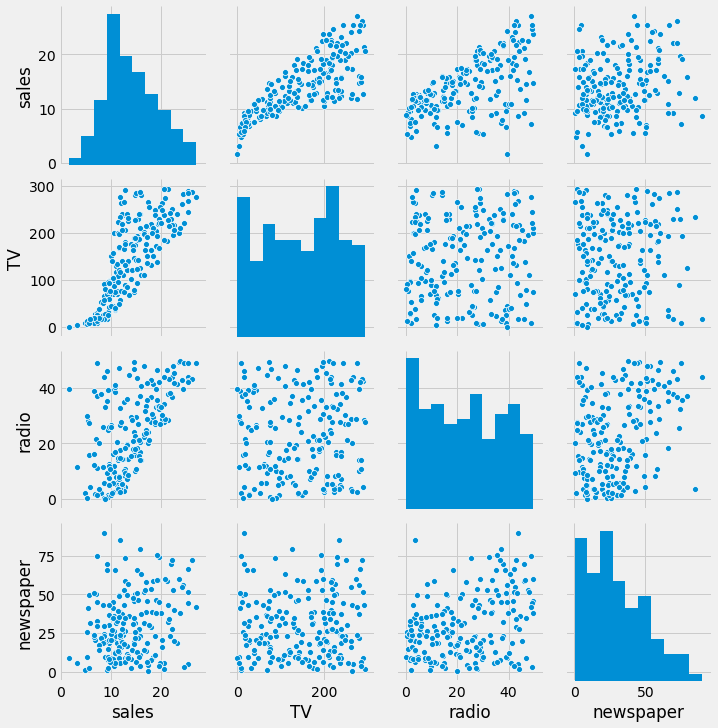

In [50]:
sns.pairplot(data=ads_pd)

It appears that newspaper does not have a relationship to sales, while TV and radio do.  A correlation matrix may be able to reinforce this.

### Correlation Matrix

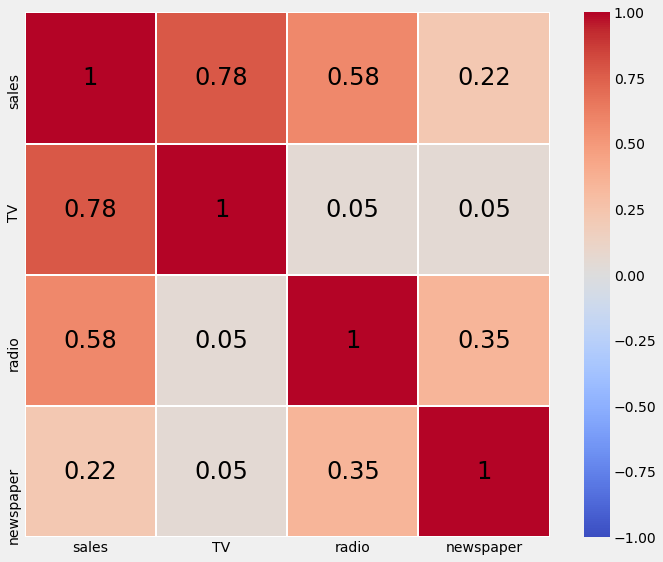

In [51]:
corr = ads_pd.corr('pearson')
corr = corr.round(2)

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap='coolwarm', vmax=1,vmin=-1, center=0, square=True, 
            annot=True,linecolor='white', linewidths=1, annot_kws={"fontsize":24, "color":'0'})

Assuming that a linear model will be used, it is fairly clear that newspaper (0.22 positive correlation value) is not going to be a relevant variable.  It can still be included in the first version of the model (as a third check), but will likely be rejected.
TV has a strong relationship and will be a solid feature regardless of the model type that is chosen.
Radio (positive correlation 0.58) is somewhere in between.

This plot tests three of the assumptions of linear regression: linear relationship, normality, and multicolinearity.  

* There are fairly strong linear relationships between radio and sales & TV and sales, but not one between newspaper and sales.

* None of the data is normally distributed, though sales is close.

* Multicollinearity does not appear to be a problem.

There are two other important takeaways: TV looks like its relationship to sales could be non-linear ($TV^2$ may perform better than $TV$), many of the observations of Radio are outside of its otherwise linear relationship with sales (either the relationship is not strong, or something else is at work).

## Create New Terms for Model

In [52]:
#create polynomial term and interaction term
ads_pd['TV:TV'] = ads_pd['TV'] * ads_pd['TV']
ads_pd['TV:radio'] = ads_pd['TV'] * ads_pd['radio']
print(ads_pd)

     sales     TV  radio  newspaper     TV:TV  TV:radio
0     22.1  230.1   37.8       69.2  52946.01   8697.78
1     10.4   44.5   39.3       45.1   1980.25   1748.85
2      9.3   17.2   45.9       69.3    295.84    789.48
3     18.5  151.5   41.3       58.5  22952.25   6256.95
4     12.9  180.8   10.8       58.4  32688.64   1952.64
..     ...    ...    ...        ...       ...       ...
195    7.6   38.2    3.7       13.8   1459.24    141.34
196    9.7   94.2    4.9        8.1   8873.64    461.58
197   12.8  177.0    9.3        6.4  31329.00   1646.10
198   25.5  283.6   42.0       66.2  80428.96  11911.20
199   13.4  232.1    8.6        8.7  53870.41   1996.06

[198 rows x 6 columns]


### Explore New Dataset

### Correlation Matrix 2

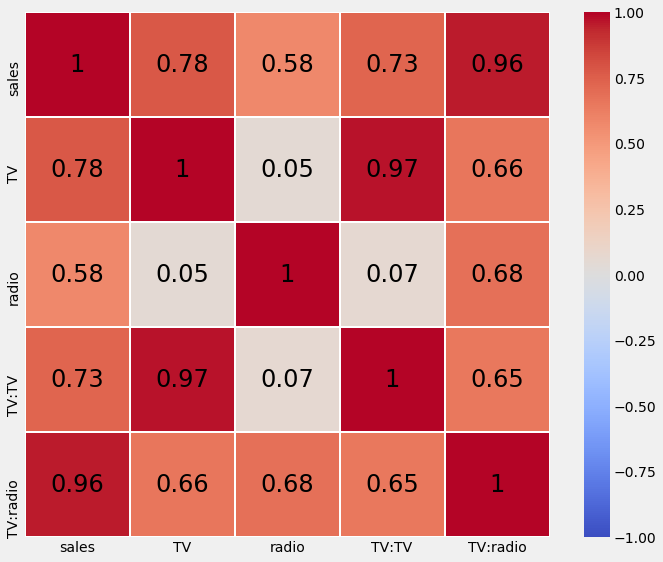

In [53]:
check_mcl = ads_pd.filter(['sales', 'TV', 'radio', 'TV:TV', 'TV:radio'])
corr = check_mcl.corr('pearson')
corr = corr.round(2)

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap='coolwarm', vmax=1,vmin=-1, center=0, square=True, 
            annot=True,linecolor='white', linewidths=1, annot_kws={"fontsize":24, "color":'0'})

### Pair Plot 2

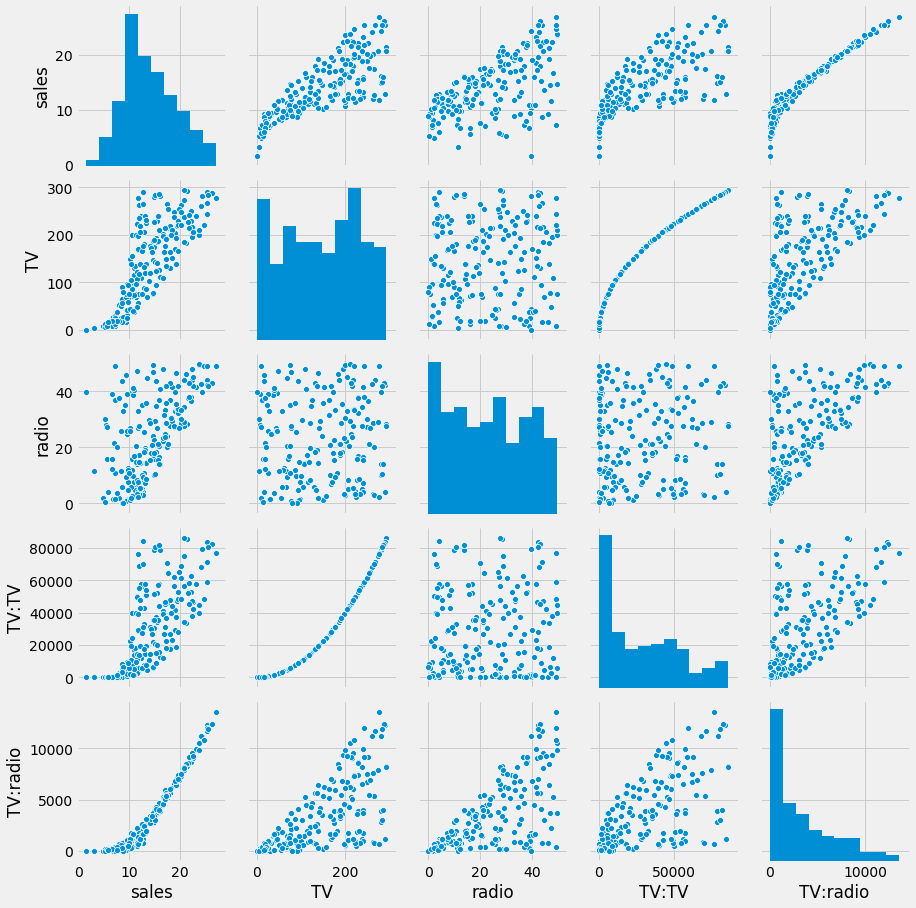

In [54]:
sns.pairplot(data=check_mcl)

## Build Statistical Model

In [55]:
import statsmodels.formula.api as smf
X = ads_pd.filter(['TV', 'radio', 'TV:TV', 'TV:radio'], axis=1)
y = ads_pd.filter(['sales'], axis=1)
lm = sm.OLS(y, sm.add_constant(X)).fit()
results = lm.summary()
results

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3350.
Date:                Thu, 06 Feb 2020   Prob (F-statistic):          4.78e-177
Time:                        09:16:41   Log-Likelihood:                -185.54
No. Observations:                 198   AIC:                             381.1
Df Residuals:                     193   BIC:                             397.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1300      0.194     26.400      0.000       4.747       5.513
TV             0.0511      0.002     22.499      0.000       0.047       0.056
radio          0.0350      0.006      5.883      0.000       0.023       0.047
TV:TV         -0.0001   7.02e-06    -15.708      0.000      -0.000   -9.65e-05
TV:radio       0.0011    3.5e-05     30.749      0.000       0.001       0.001
==============================================================================
Omnibus:                      167.025   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3894.060
Skew:                          -2.959   Prob(JB):                         0.00
Kurtosis:                      23.904   Cond. No.                     1.68e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Important statistics to note:
* The p-values for each feature are smaller than 0.001, which is great, and shows that their positive influence on the model is not based on chance
* The adjusted r-squared 0.986 (identical to the r-squared), which is also great, and means that the model almost perfectly fits the data
* The condition number is large.  This is not a good sign, and is usually the result of multicolinearity.

Multicolinearity can be a problem in a linear model (as it negates one of the assumptions of linear regression).  However, in cases where a polynomial term or interaction term are used with the original term ($X$ and $X^2$ for instance), this is not a problem.
There are several reasons for this:
1. the p-values and r-squared will be lower and higher, respectively
2. The multicolinearity disappears if you center the original term by subtracting the mean of the feature vector before transforming them.
3. More on this [here](https://statisticalhorizons.com/multicollinearity).

If there were lower p-values and r-squared values, it may be concerning enough to try building several models with and without these terms, but in this case its fine to move on.


The final version will include:
* TV
* Radio
* TV:Radio
* TV:TV

The coefficients of these features can be extracted from the final model and used in a constrained optimization problem.

## Build Machine Learning Model

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = ads_pd

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=29)



rfr = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=8)
y = np.array(y).flatten()
X

,sales,TV,radio,newspaper,TV:TV,TV:radio
0,22.1,230.1,37.8,69.2,52946.01,8697.78
1,10.4,44.5,39.3,45.1,1980.25,1748.85
2,9.3,17.2,45.9,69.3,295.84,789.48
3,18.5,151.5,41.3,58.5,22952.25,6256.95
4,12.9,180.8,10.8,58.4,32688.64,1952.64
...,...,...,...,...,...,...
195,7.6,38.2,3.7,13.8,1459.24,141.34
196,9.7,94.2,4.9,8.1,8873.64,461.58
197,12.8,177.0,9.3,6.4,31329.00,1646.10
198,25.5,283.6,42.0,66.2,80428.96,11911.20


In [57]:
rfr.fit(X,y)
pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, pred).round(4)
r2 = r2_score(y_test, pred).round(4)

scores = [mse, r2]

score_table = pd.DataFrame(scores, index=['MSE', 'R-Squared'], columns=['Scores'])
score_table

,Scores
MSE,0.0131
R-Squared,0.9996


These results are fantastic.  Almost all of the variance is explained and the model generalized to unseen data very well.  Now this model can be used as part of the objective function of a constrained optimization problem.

For this purpose,
1. he objective function will be defined
2. An inequality constraint will be set (sum of all variables must be less than 400) to represent the overall budget for the marketing effort
3. x0 will be initialized as a vector of the initial guesses for each coefficient weight
4. Bounds will be set for demonstrative purpose, though bounds are very useful and can also represent domain relevant information
5. The objective function will be minimized with scipy minimize, using the SLSQP solver/method, and the functions from 1:4
6. Finally, the results of the opimization will be displayed on a table

In [58]:
def objective(x):
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    X_state = [[x0, x1, x2, x3, x4, x5]]
    sol = -(rfr.predict(X_state)[0])
    return sol
objective([5,5,5,5,5,5])

-4.158

In [0]:
def constraint1(x):
    con = x[0] + x[1] + x[2] + x[3] + x[4] + x[5] - 400
    return con

con1 = {'type': 'eq', 'fun': constraint1}

In [0]:
x0 = np.array([5,5,5,5,5,5])

In [0]:
bnds = [(50, 260), (50, 100), (0, 51),(50, 260), (50, 100), (0, 51)]

In [62]:
res = minimize(objective, x0, method='SLSQP', constraints=con1, bounds=bnds)
print(res)

     fun: -21.220000000000006
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([81.66666667, 81.66666667, 36.66666667, 81.66666667, 81.66666667,
       36.66666667])


In [63]:
optimal = [[res.x[0], res.x[1], res.x[2], res.fun, res.success]]
opt_table = pd.DataFrame(optimal, columns=['x0', 'x1', 'x2', 'Value', 'Successful'])
opt_table

,x0,x1,x2,Value,Successful
0,81.666667,81.666667,36.666667,-21.22,True
